In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from Utils.dataset import PreloadedDataset
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

import math

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else "cpu"
# device = torch.device('cpu')
device

device(type='cuda')

  0%|          | 0/60000 [00:00<?, ?it/s]

Loaded MNIST with 60000 samples


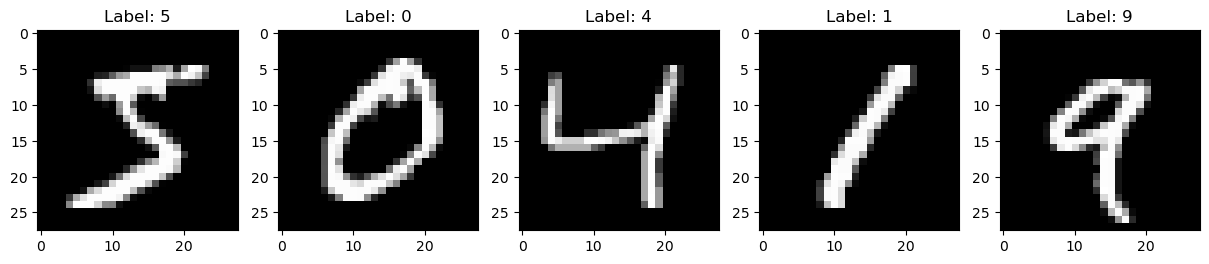

In [285]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

subset_size = 10000
raw_dataset = datasets.MNIST(root="../Datasets/", train=True, transform=transform, download=False)
# raw_dataset = torch.utils.data.Subset(raw_dataset, range(subset_size))

positive_dataset = PreloadedDataset.from_dataset(raw_dataset, transforms.ToTensor(), device)
print(f'Loaded MNIST with {len(positive_dataset)} samples')
# show first samples
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axs[i].imshow(np.squeeze(positive_dataset[i][0].cpu().numpy()), cmap='gray')
    axs[i].set_title(f"Label: {positive_dataset[i][1]}")
plt.show()

In [369]:
def step(x, E, R, Us, y=None, corr_coeff=1.0):
    inp = x
    for i in range(len(Us)):
        E[i] = inp - Us[i](R[i])
        R[i] = R[i] + F.linear(E[i], Us[i].weight.T, None)
        # if i < len(Us) - 1:
        #     R[i] += 0.1*E[i+1]
        inp = R[i]
    if y is not None:
        y_norm = y / torch.norm(y)
        y_scaled = y_norm * torch.norm(R[-1])
        R[-1] = (corr_coeff*y_scaled) + ((1-corr_coeff)*R[-1])
    return E, R

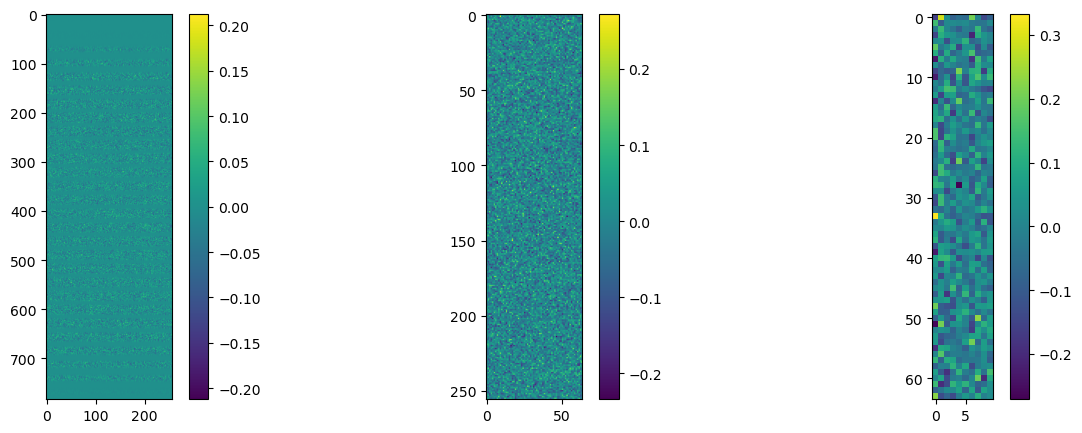

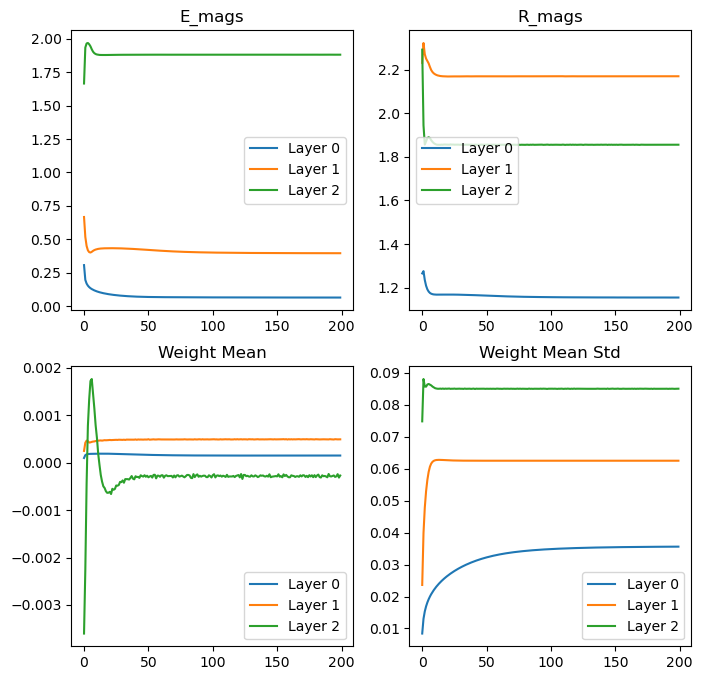

In [406]:
# Parameter Initialisation
sizes = [784, 256, 64, 10]
steps = 4
Us = [nn.Linear(sizes[i+1], sizes[i], bias=True) for i in range(len(sizes)-1)]
for i in range(len(Us)):
    Us[i].weight.data *= 0.1
    Us[i] = Us[i].to(device)

# Track epochs indexed: [layer][epoch]
epochs_E_mags = [[] for _ in range(len(Us))]
epochs_R_mags = [[] for _ in range(len(Us))]
epochs_Us_mags = [[] for _ in range(len(Us))]
epochs_Us_stds = [[] for _ in range(len(Us))]

# Hyperparameters
lr = 0.00034
reg_coeff = 2.0
corr_coeff = 1.0
EPOCHS = 200
BATCH_SIZE = 256

dataloader = torch.utils.data.DataLoader(positive_dataset, batch_size=BATCH_SIZE, shuffle=True)

track = True
if track:
    E_track = [[[torch.zeros(sizes[layer_i]) for layer_i in range(len(Us))] for step_i in range(steps)] for epoch_i in range(EPOCHS)]
    R_track = [[[torch.zeros(sizes[layer_i+1]) for layer_i in range(len(Us))] for step_i in range(steps)] for epoch_i in range(EPOCHS)]
    Us_track = [[torch.zeros((sizes[layer_i+1] * sizes[layer_i])) for layer_i in range(len(Us))] for epoch_i in range(EPOCHS)]
track_batch = 0

# Learning Loop
for ep in range(EPOCHS):
    # Track batches indexed: [layer][batch]
    batches_E_mags = [[] for _ in range(len(Us))]
    batches_R_mags = [[] for _ in range(len(Us))]
    batches_Us_mags = [[] for _ in range(len(Us))]
    batches_Us_stds = [[] for _ in range(len(Us))]

    # for idx in range(len(positive_dataset)):
    loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=False)
    if ep > 0:
        temp_e = torch.zeros(len(Us))
        for i in range(len(Us)):
            temp_e[i] = epochs_E_mags[i][-1]
        loop.set_description(f"Epoch {ep+1}/{EPOCHS} - E: {temp_e.mean().item():.6f}")
    # loop = enumerate(dataloader)
    for batch_i, (x, y) in loop:
        x = x.flatten(start_dim=1).to(device)
        y = F.one_hot(y, num_classes=sizes[-1]).float().to(device)
        batch_size = x.shape[0]

        E = [torch.zeros((batch_size, sizes[i],)).to(device) for i in range(len(sizes)-1)]
        R = [torch.zeros((batch_size, sizes[i+1],)).to(device) for i in range(len(sizes)-1)]
        # R[-1] = y

        for step_i in range(steps):
            with torch.no_grad():
                E, R = step(x, E, R, Us, y, corr_coeff)

            if step_i > 0:
                with torch.no_grad():
                    for i in range(len(Us)):
                        # print(f"shapes: {E[i].T.shape}, {R[i].shape}, {Us[i].weight.shape}")
                        Us[i].weight.grad = -(E[i].T @ R[i])/batch_size # -ve because we are performing grad descent, yet we want to increase connectivity 
                        if Us[i].bias is not None:
                            Us[i].bias.grad = Us[i].bias - x.mean(axis=0) if i == 0 else Us[i].bias - R[i-1].mean(axis=0) 

                reg = reg_coeff * sum([U.weight.square().mean() for U in Us]) # L2
                # reg = reg_coeff * sum([U.weight.abs().mean() for U in Us]) # L1
                reg.backward()
                
                # Parameter Update
                for i in range(len(Us)):
                    Us[i].weight.data -= lr * Us[i].weight.grad
                    if Us[i].bias is not None:
                        Us[i].bias.data -= lr * Us[i].bias.grad

                if batch_i == track_batch and track:
                    for i in range(len(Us)):
                        E_track[ep][step_i][i] = E[i].clone()
                        R_track[ep][step_i][i] = R[i].clone()
                        if step_i == 1:
                            Us_track[ep][i] = Us[i].weight.flatten().clone().detach()

        # # plot grads
        # if ep == 9:
        #     plt.figure(figsize=(15, 5))
        #     for i in range(len(Us)):
        #         plt.subplot(1, len(Us), i+1)
        #         plt.imshow(Us[i].weight.grad.cpu().numpy())
        #         plt.colorbar()
        #     plt.show()


        # Track batches
        temp_e = torch.zeros(len(Us))
        for i in range(len(Us)):
            batches_E_mags[i].append(E[i].abs().mean().item())
            batches_R_mags[i].append(R[i].abs().mean().item())
            # batches_Us_mags[i].append(Us[i].weight.data.abs().mean().item())
            batches_Us_mags[i].append(Us[i].weight.data.mean().item())
            batches_Us_stds[i].append(Us[i].weight.data.std().item())
        

    # Track epochs
    for i in range(len(Us)):
        epochs_E_mags[i].append(torch.tensor(batches_E_mags[i]).mean().item())
        epochs_R_mags[i].append(torch.tensor(batches_R_mags[i]).mean().item())
        epochs_Us_mags[i].append(torch.tensor(batches_Us_mags[i]).mean().item())
        epochs_Us_stds[i].append(torch.tensor(batches_Us_stds[i]).mean().item())

# Plot weights
plt.figure(figsize=(15, 5))
for i in range(len(Us)):
    plt.subplot(1, len(Us), i+1)
    plt.imshow(Us[i].weight.data.cpu().numpy())
    plt.colorbar()
plt.show()

# Plot
fig, axs = plt.subplots(2,2, figsize=(8,8))
for i in range(len(Us)):
    axs[0,0].plot(epochs_E_mags[i], label=f"Layer {i}")
    axs[0,0].set_title('E_mags')
    axs[0,0].legend()
    axs[0,1].plot(epochs_R_mags[i], label=f"Layer {i}")
    axs[0,1].set_title('R_mags')
    axs[0,1].legend()
    axs[1,0].plot(epochs_Us_mags[i], label=f"Layer {i}")
    axs[1,0].set_title('Weight Mean')
    axs[1,0].legend()
    axs[1,1].plot(epochs_Us_stds[i], label=f"Layer {i}")
    axs[1,1].set_title('Weight Mean Std')
    axs[1,1].legend()
plt.show()

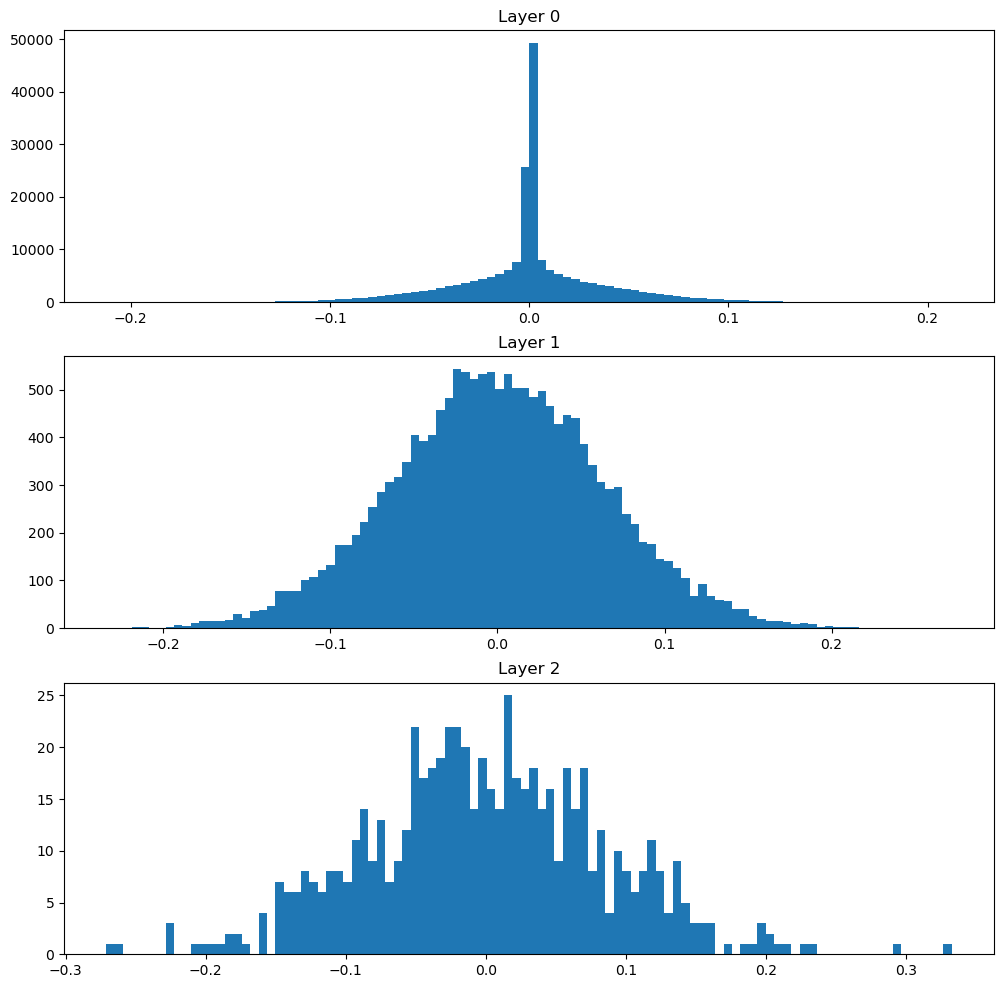

In [407]:
# Plot Us_track histogram

epoch_i = 1

# weights = [Us_track[epoch_i][i].cpu().numpy().flatten() for i in range(len(Us))]
weights = [Us[i].weight.data.cpu().numpy().flatten() for i in range(len(Us))]

fig, axs = plt.subplots(len(Us), figsize=(12, 12))
for i in range(len(Us)):
    axs[i].hist(weights[i], bins=100)
    axs[i].set_title(f"Layer {i}")
plt.show()

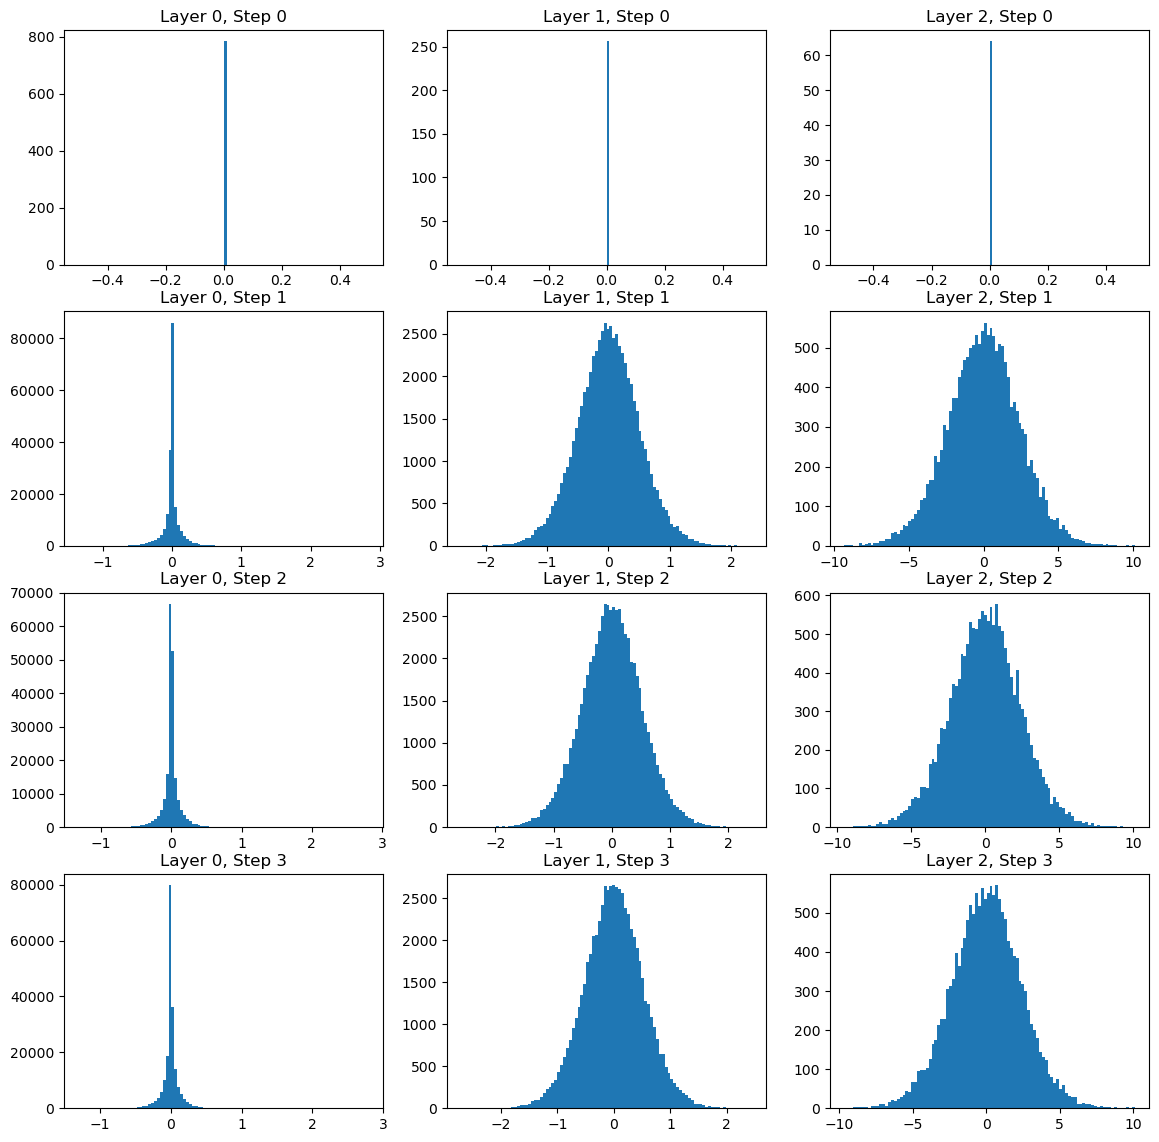

In [377]:
# Plot E_track histogram

epoch_i = 49
# step_i = 4

fig, axs = plt.subplots(steps, len(Us), figsize=(14, 14))
for i in range(len(Us)):
    for step_i in range(steps):
        axs[step_i,i].hist(E_track[epoch_i][step_i][i].cpu().numpy().flatten(), bins=100)
        axs[step_i,i].set_title(f"Layer {i}, Step {step_i}")
plt.show()

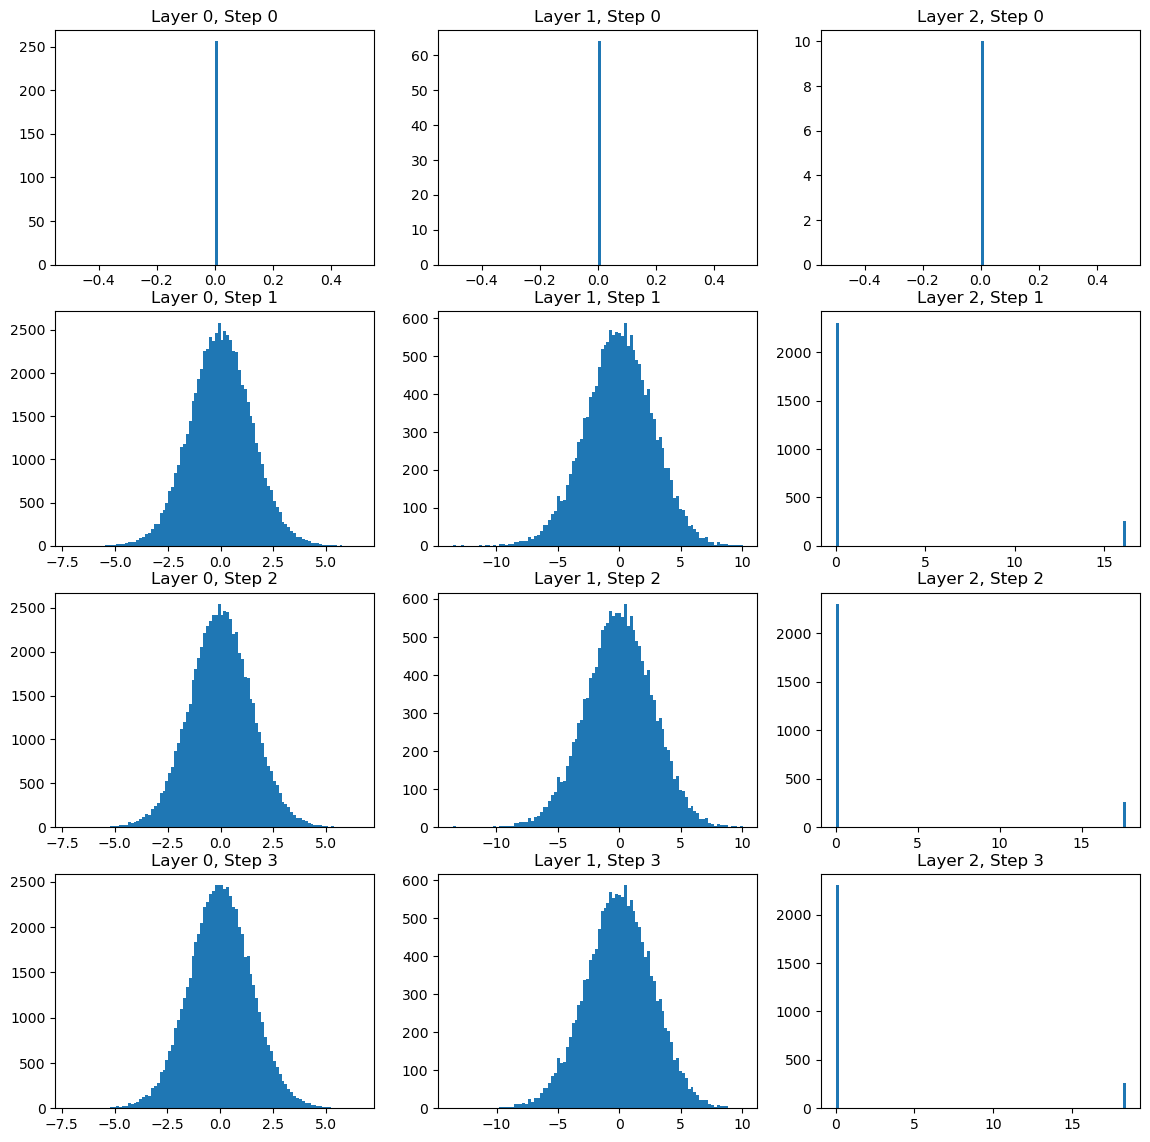

In [378]:
epoch_i = 49
# step_i = 4

# Plot R_track histogram
fig, axs = plt.subplots(steps, len(Us), figsize=(14, 14))
for i in range(len(Us)):
    for step_i in range(steps):
        axs[step_i,i].hist(R_track[epoch_i][step_i][i].cpu().numpy().flatten(), bins=100)
        axs[step_i,i].set_title(f"Layer {i}, Step {step_i}")
plt.show()

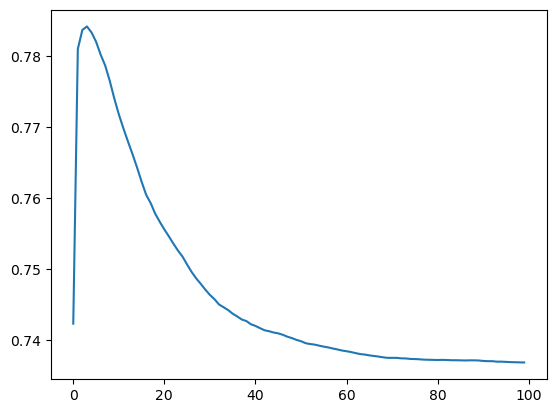

In [413]:
dataloader = torch.utils.data.DataLoader(positive_dataset, batch_size, shuffle=False)
t_steps = 100
correct = [0 for _ in range(t_steps)]
batch_size = 128
for x, y in dataloader:
    # print(f"\nData {idx}: {y}")
    bs = x.shape[0]
    x = x.flatten(start_dim=1).to(device)
    E = [torch.zeros((bs, sizes[i],)).to(device) for i in range(len(sizes)-1)]
    R = [torch.zeros((bs, sizes[i+1],)).to(device) for i in range(len(sizes)-1)]

    for step_i in range(t_steps):
        with torch.no_grad():
            E, R = step(x, E, R, Us)
        
        pred = R[-1].argmax(dim=1)
        correct[step_i] += (pred == y).sum().item()

acc = [c/len(positive_dataset) for c in correct]
# print(acc)
plt.plot(acc)

In [394]:
num = 3
idxs = np.random.choice(len(positive_dataset), num, replace=False)
for idx in idxs:
    x, y = positive_dataset[idx]
    print(f"\nData {idx}: {y}")
    x = x.flatten(start_dim=1).to(device)
    E = [torch.zeros((1, sizes[i],)).to(device) for i in range(len(sizes)-1)]
    R = [torch.zeros((1, sizes[i+1],)).to(device) for i in range(len(sizes)-1)]

    for step_i in range(4):
        with torch.no_grad():
            E, R = step(x, E, R, Us)
        
        pred = R[-1].argmax().item()
        if step_i == 0 or step_i == 3:
            print(f"Step {step_i+1}: {pred}")




Data 5533: 4
Step 1: 4
Step 4: 4

Data 2236: 4
Step 1: 0
Step 4: 0

Data 15040: 2
Step 1: 2
Step 4: 2



Data 0: 5
r0 mean: 1.4333819150924683 - std: 1.0566198825836182 - max: 4.837357521057129 - min: 0.0002630576491355896
r1 mean: 2.6965479850769043 - std: 1.9347612857818604 - max: 8.416234016418457 - min: 0.007342129945755005
r2 mean: 3.6159281730651855 - std: 2.504835844039917 - max: 9.122943878173828 - min: 0.03943014144897461
r3 mean: 145886691328.0 - std: 18243102720.0 - max: 169659695104.0 - min: 110651645952.0


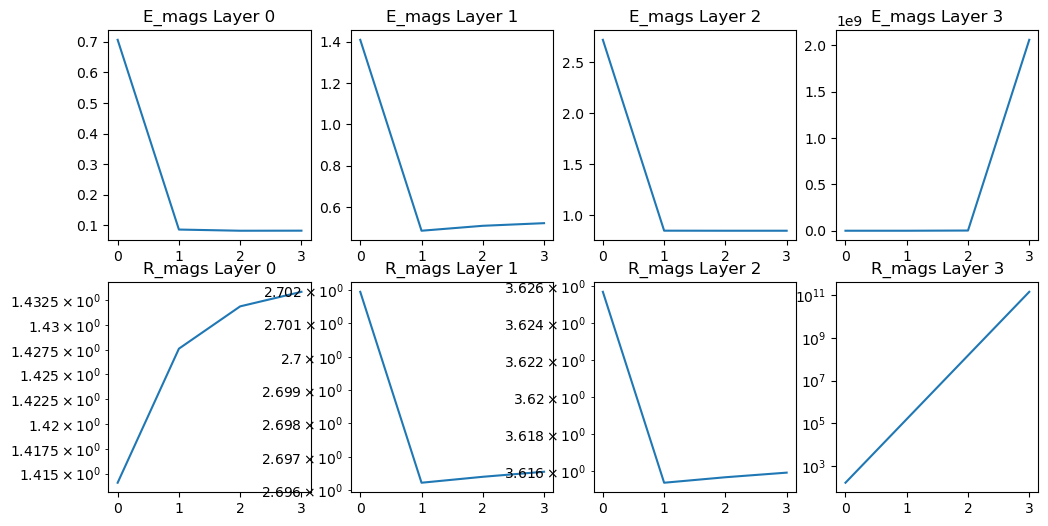

In [108]:
idx = 0
x, y = positive_dataset[idx]
print(f"\nData {idx}: {y}")
x = x.flatten(start_dim=1).to(device)
E = [torch.zeros((1, sizes[i],)).to(device) for i in range(len(sizes)-1)]
R = [torch.zeros((1, sizes[i+1],)).to(device) for i in range(len(sizes)-1)]

Es  = [[] for _ in range(len(Us))]
Rs = [[] for _ in range(len(Us))]
preds = []
for step_i in range(4):
    with torch.no_grad():
        E, R = step(x, E, R, Us)
        for i in range(len(Us)):
            Es[i].append(E[i].abs().mean().item())
            Rs[i].append(R[i].abs().mean().item())
    pred = R[-1].argmax().item()
    preds.append(pred)

for i in range(len(Us)):
    print(f"r{i} mean: {R[i].abs().mean().item()} - std: {R[i].abs().std().item()} - max: {R[i].abs().max().item()} - min: {R[i].abs().min().item()}")

fig, axs = plt.subplots(2, len(Us), figsize=(12,6))
for i in range(len(Us)):
    axs[0,i].plot(Es[i])
    axs[0,i].set_title(f"E_mags Layer {i}")
    axs[1,i].plot(Rs[i])
    axs[1,i].set_title(f"R_mags Layer {i}")
    axs[1,i].set_yscale('log')
plt.show()

In [51]:
def measure_errs(
        model,
        dataloader,
):
    E = [0.0 for _ in range(len(model.layers))]

    for batch_idx, (images, _) in enumerate(dataloader):
        images = images.flatten(start_dim=1)
        state = model(images, steps=5)
        for i, e in enumerate(state[0]):
            E[i] += e.abs().mean()
    
    for i in range(len(E)):
        E[i] /= batch_idx+1

    return E

def train(
        model,
        positive_dataset,
        negative_dataset,
        batch_size,
        lr,
        epochs,
        measure_errs_every=1,
        step=0,
):
    # writer = SummaryWriter("Deep_Learning/Experimental/Hebbian_Learning/mnist/out/logs")
    Es = [[] for _ in range(len(model.layers))]
    layer_reg_coeff = [0.3, 0.1]
    positive_dataloader = torch.utils.data.DataLoader(positive_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        negative_dataset = mix_dataset(negative_dataset)
        negative_dataloader = torch.utils.data.DataLoader(negative_dataset, batch_size=batch_size, shuffle=True)
        
        # For some dumb reason, i have to reinitialise the loop every epoch
        loop = tqdm(enumerate(positive_dataloader), total=len(positive_dataloader), leave=False) 

        neg_it = iter(negative_dataloader)
        for batch_idx, (images, y) in loop:
            images = images.flatten(start_dim=1)

            for phase in range(2):
                phase_coeff = 1.0
                if phase == 1: # Negative phase
                    continue
                    # images = torch.randn_like(images)
                    images = next(neg_it)[0].flatten(start_dim=1)
                    phase_coeff = -0.5

                state = model.init_state(len(images))
                for step_i in range(4):
                    state = model.step(images, state)
                    if step_i > 0:
                        model.zero_grad()
                        reg = -1.0 * sum(l.weight.square().mean() for l in model.layers)
                        reg.backward()
                        
                        for i in range(len(model.layers)):
                            model.layers[i].weight.grad += -state[0][i].T @ state[1][i]
                            model.layers[i].weight.grad /= len(images)
                            # print(f'epoch: {epoch}, batch: {batch_idx}, layer: {i}, phase: {phase}, step: {step_i}')
                            # print(f'e_mag: {state[0][i].abs().mean()}, r_mag: {state[1][i].abs().mean()}')
                            # print(model.layers[i].weight.grad.abs().mean())
                            model.layers[i].weight.data += phase_coeff*lr*model.layers[i].weight.grad

            step += len(images)

        if epoch % measure_errs_every == 0:
            E = measure_errs(model, positive_dataloader)
            for i, e in enumerate(E):
                Es[i].append(e)

    return Es, step

In [67]:
positive_dataset[0][0].flatten().mean()

tensor(0.0227)

In [58]:
model = Model(784, 64, [])
for layer in model.layers:
    layer.weight.data *= 0.01
step = 0

In [11]:
batch_size = 4
dataloader = torch.utils.data.DataLoader(positive_dataset, batch_size=batch_size, shuffle=True)
x = next(iter(dataloader))[0].flatten(start_dim=1)
state = model.init_state(len(x))

state = model.step(x, state)
state = model.step(x, state)
state = model.step(x, state)
state = model.step(x, state)
state = model.step(x, state)
state = model.step(x, state)

for i in range(len(model.layers)):
    print(f'layer: {i}, e_mag: {state[0][i].abs().mean()}, r_mag: {state[1][i].abs().mean()}')


layer: 0, e_mag: 0.717157781124115, r_mag: 0.04973415285348892
layer: 1, e_mag: 0.058073725551366806, r_mag: 0.0022778718266636133
layer: 2, e_mag: 0.06193847954273224, r_mag: 0.0026818341575562954


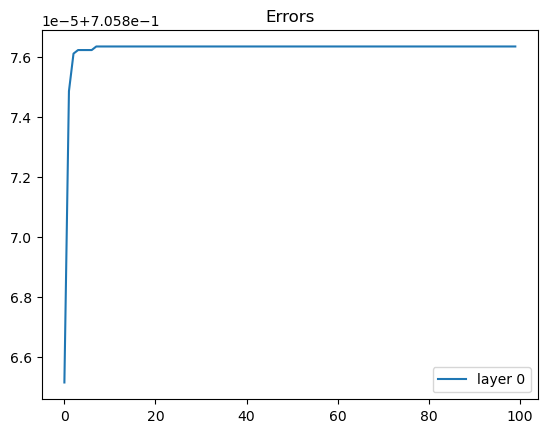

In [57]:
batch_size = 1
lr = 0.0001
optimiser = torch.optim.AdamW(model.parameters(), lr, weight_decay=1.0)
epochs=100
Es, step = train(
    model,
    positive_dataset,
    negative_dataset,
    batch_size,
    lr,
    epochs,
    step=step,
)
# plot logarithmic
for i, e in enumerate(Es):
    plt.plot(e, label=f'layer {i}')
# plt.yscale('log')
plt.legend()
plt.title('Errors')
plt.show()

In [79]:
for i, e in enumerate(Es):
    print(max(e))

tensor(2.2823e+28)


In [ ]:
for layer in model.layers:
    print(layer.weight.abs().mean(), layer.bias.abs().mean())

tensor(0.0613, grad_fn=<MeanBackward0>) tensor(0.0634, grad_fn=<MeanBackward0>)
tensor(0.0312, grad_fn=<MeanBackward0>) tensor(0.0274, grad_fn=<MeanBackward0>)


In [ ]:
positive_sample = positive_dataset[0][0].flatten().unsqueeze(0)
negative_sample = negative_dataset[0][0].flatten().unsqueeze(0)
random_sample = torch.randn_like(positive_sample)

out1 = model(positive_sample)
out2 = model(negative_sample)
out3 = model(random_sample)

print(out1[0][0].abs().mean())
print(out1[0][1].abs().mean())
print(out2[0][0].abs().mean())
print(out2[0][1].abs().mean())
print(out3[0][0].abs().mean())
print(out3[0][1].abs().mean())


tensor(1.0533)
tensor(2.9642)
tensor(1.0847)
tensor(2.9922)
tensor(0.9877)
tensor(2.7128)
